# 1° Importação Dos Dados

In [6]:
import os                              # Importa o módulo os para interagir com o sistema operacional.
import shutil                          # Importa o módulo shutil para operações de arquivo de alto nível (por exemplo, copiar, mover).
import cv2                             # Importa OpenCV, uma biblioteca para processamento de imagem e visão computacional.
import pandas as pd                    # Importa Pandas, uma biblioteca para manipulação e análise de dados.
import matplotlib.pyplot as plt        # Importa a biblioteca Matplotlib para criação de gráficos e visualizações.
import numpy as np                     # Importa NumPy, uma biblioteca para operações matemáticas e manipulação de arrays.
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 2° Carregar Dados

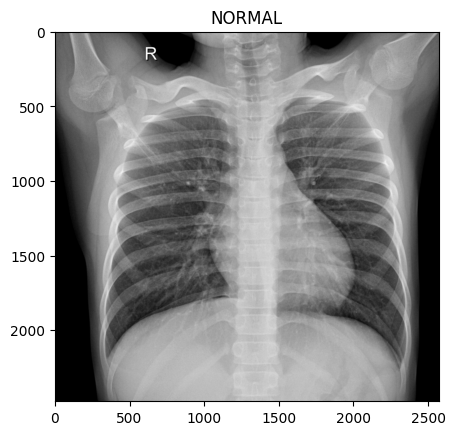

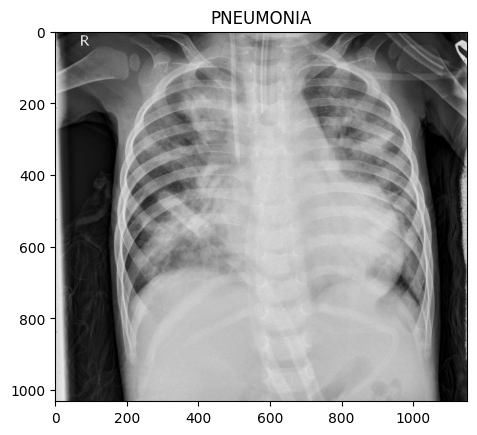

In [7]:

DATADIR = 'chest_xray'
CATEGORIES = ["NORMAL", "PNEUMONIA"]

train_dir = os.path.join(DATADIR, 'train')
test_dir = os.path.join(DATADIR, 'test')

# Função para visualizar algumas imagens
def visualize_images(directory, categories):
    for category in categories:
        path = os.path.join(directory, category)
        x = 0
        for img in os.listdir(path):
            x += 1
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            plt.imshow(img_array, cmap='gray')
            plt.title(category)
            plt.show()
            if x == 1:
                break

# Visualizar algumas imagens do conjunto de treino
visualize_images(train_dir, CATEGORIES)

# 3° Processamento dos Dados

In [8]:
# Configuração do ImageDataGenerator para dados de treino, validação e teste
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5232 images belonging to 2 classes.
Found 622 images belonging to 2 classes.


# 4° Construção da Máquina Preditiva - IA com Deep Learning

In [9]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.optimizers import Adam

# Carregar o modelo VGG16 pré-treinado sem as camadas superiores (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar as camadas da base do modelo
for layer in base_model.layers:
    layer.trainable = False

# Adicionar camadas densas personalizadas no topo do modelo VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Construir o modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Definir a taxa de aprendizado desejada
learning_rate = 0.0001

# Compilar o modelo com a taxa de aprendizado ajustada
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Resumo do modelo
model.summary()

# Treinar o modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=5
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,521 (60.13 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/5


c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 929s 6s/step - accuracy: 0.8739 - loss: 0.2808 - val_accuracy: 0.8141 - val_loss: 0.3745
Epoch 2/5
  1/163 ━━━━━━━━━━━━━━━━━━━━ 13:37 5s/step - accuracy: 1.0000 - loss: 0.0713

c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 1.0000 - loss: 0.0359 - val_accuracy: 1.0000 - val_loss: 0.0157
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 918s 6s/step - accuracy: 0.9714 - loss: 0.0874 - val_accuracy: 0.8618 - val_loss: 0.2979
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9688 - loss: 0.0327 - val_accuracy: 1.0000 - val_loss: 0.0158
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 920s 6s/step - accuracy: 0.9744 - loss: 0.0706 - val_accuracy: 0.8849 - val_loss: 0.2595


# 5° Avaliação Do Modelo 

20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step


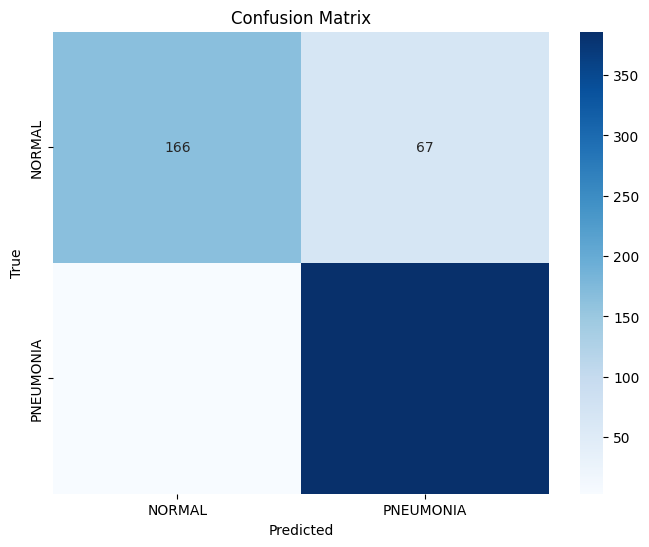

              precision    recall  f1-score   support

      NORMAL       0.98      0.71      0.83       233
   PNEUMONIA       0.85      0.99      0.92       389

    accuracy                           0.89       622
   macro avg       0.92      0.85      0.87       622
weighted avg       0.90      0.89      0.88       622



In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Obter previsões do modelo no conjunto de teste
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# Obter rótulos verdadeiros do conjunto de teste
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


# Fazendo nova predição

In [13]:
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

def load_and_preprocess_image(img_path, target_size=(150, 150)):
    # Carregar a imagem
    img = image.load_img(img_path, target_size=target_size)
    # Converter a imagem em um array
    img_array = image.img_to_array(img)
    # Adicionar uma dimensão extra para representar o lote
    img_array = np.expand_dims(img_array, axis=0)
    # Pré-processar a imagem para o modelo VGG16
    img_array = preprocess_input(img_array)
    return img_array

def make_prediction(model, img_path):
    # Pré-processar a imagem
    img_array = load_and_preprocess_image(img_path)
    # Fazer a predição
    prediction = model.predict(img_array)
    # Converter a predição em uma classe binária (0 ou 1)
    predicted_class = int(np.where(prediction > 0.5, 1, 0).flatten()[0])
    # Obter a probabilidade associada à classe prevista
    predicted_probability = prediction.flatten()[0] if predicted_class == 1 else 1 - prediction.flatten()[0]
    return predicted_class, predicted_probability

# Exemplo de uso
img_path = 'pneumonia.jpg'
predicted_class, predicted_probability = make_prediction(model, img_path)
class_labels = list(test_generator.class_indices.keys())
print(f'Predicted class: {class_labels[predicted_class]}')
print(f'Probability: {predicted_probability:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Predicted class: PNEUMONIA
Probability: 1.00


# 6° Salvamento ou Deploy da Máquina Preditiva

In [14]:
# Salvar o modelo treinado
model.save('modelo_vgg16_pneumonia.h5')

# Se desejar, você também pode salvar o histórico de treinamento para análise posterior
import pickle

with open('historico_treinamento.pkl', 'wb') as f:
    pickle.dump(history.history, f)
